In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# Cargar datos
path_datos = os.path.join('..','..','Datos','Limpios')
df2 = pd.read_csv(os.path.join(path_datos,'datos2_limpios.csv'), index_col=0)

df2_limpio = df2.drop(['Porcentaje Ahorro (%)', 'Ahorro Actual (€)', 'Gasto Mensual (€)',
                        'Vida Esperada (años)', 'Edad de Jubilación'], axis=1)

In [3]:
# Definir variables de entrada y salida
X = df2_limpio.drop(columns=['Años Hasta Jubilación'])
y = df2_limpio['Años Hasta Jubilación']

In [4]:
# Dividir en train y test
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.5, random_state=42)

### Modelos base

In [31]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor


dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

rb= RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=100, random_state=42)
rb.fit(X_train, y_train)

gb= GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_split=10, n_estimators=180)
gb.fit(X_train, y_train)

et=  ExtraTreesRegressor(max_depth=10, min_samples_split=10, n_estimators=200, random_state=42)
et.fit(X_train, y_train) 

ExtraTreesRegressor(max_depth=10, min_samples_split=10, n_estimators=200,
                    random_state=42)

In [9]:
from sklearn.metrics import r2_score

dt_r2 = r2_score(y_train, dt.predict(X_train))
rb_r2 = r2_score(y_train, rb.predict(X_train))
gb_r2 = r2_score(y_train, gb.predict(X_train))
et_r2 = r2_score(y_train, et.predict(X_train))

print(dt, "Model R2 Score: ", dt_r2)
print(rb, "Model R2 Score: ", rb_r2)
print(gb, "Model R2 Score: ", gb_r2)
print(et, "Model R2 Score: ", et_r2)

DecisionTreeRegressor() Model R2 Score:  0.9963057671997054
RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=42) Model R2 Score:  0.987977111232645
GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_split=10,
                          n_estimators=180) Model R2 Score:  0.9826853814097158
ExtraTreesRegressor(max_depth=10, min_samples_split=10, n_estimators=200,
                    random_state=42) Model R2 Score:  0.9846491071893475


### Predicciones en el conjunto de validación

In [32]:
dt_predictions = dt.predict(X_val)
rb_predictions = rb.predict(X_val)
gb_predictions = gb.predict(X_val)
et_predictions = et.predict(X_val)

X_val_base = pd.DataFrame({'DT': dt_predictions,'RB': rb_predictions,'GB': gb_predictions, 'ET': et_predictions, })
X_val_base.head()

,DT,RB,GB,ET
0,38.461538,38.433016,38.447922,38.402143
1,38.461538,38.433016,38.447922,38.402143
2,27.000000,25.258074,24.345927,24.498478
3,4.000000,3.083357,3.445617,3.456806
4,39.000000,38.579542,37.480273,37.739193


### Modelo de stacking

In [33]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_val_base, y_val)

LinearRegression()

In [34]:
lr_r2 = r2_score(y_val, lr.predict(X_val_base))

print(lr, "Model R2 Score: ", lr_r2)

LinearRegression() Model R2 Score:  0.9813859477109081


### Evaluación del modelo

In [15]:
rb_test_predictions = rb.predict(X_test)
dt_test_predictions = dt.predict(X_test)
gb_test_predictions = gb.predict(X_test)
et_test_predictions = et.predict(X_test)


X_test_base = pd.DataFrame({ 'DT': dt_test_predictions,'RB': rb_test_predictions,'GB': gb_test_predictions,
                            'ET': et_test_predictions})

lr_test_predictions = lr.predict(X_test_base)

print("RB Model R2 Score: ", r2_score(y_test, rb_test_predictions))
print("DT Model R2 Score: ", r2_score(y_test, dt_test_predictions))
print("GB Model R2 Score: ", r2_score(y_test, gb_test_predictions))
print("ET Model R2 Score: ", r2_score(y_test, et_test_predictions))
print("Linear Regression Model R2 Score: ", r2_score(y_test, lr_test_predictions))

RB Model R2 Score:  0.9800618665344092
DT Model R2 Score:  0.9685518773561045
GB Model R2 Score:  0.9822622025167929
ET Model R2 Score:  0.981714845085815
Linear Regression Model R2 Score:  0.9822540790247021


### Comparación con el modelo final sin stacking

In [ ]:
lr_no_stacking_training_set = LinearRegression()
lr_no_stacking_training_set.fit(X_train, y_train)

lr_no_stacking_training_set_r2 = r2_score(y_test, lr_no_stacking_training_set.predict(X_test))
print("Linear Regression Model on Training Set R2 Score (No Stacking): ", lr_no_stacking_training_set_r2)

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
lr_no_stacking_training_validation_set = LinearRegression()
lr_no_stacking_training_validation_set.fit(X_train_val, y_train_val)

lr_no_stacking_training_validation_set_r2 = r2_score(y_test, lr_no_stacking_training_validation_set.predict(X_test))
print("Linear Regression Model on Training + Validation Set R2 Score (No Stacking): ", lr_no_stacking_training_validation_set_r2)

### Usar el modelo en dataset2

In [35]:
lr = LinearRegression()
lr.fit(X_val_base, y_val)

LinearRegression()

In [36]:
# Cargar nuevo dataset
df = pd.read_csv(os.path.join(path_datos, 'datos1_limpios.csv'), index_col=0)

In [37]:
X_2 = df.drop(['ID', 'FECHA NAC', 'SEXO', 'FECHA ENTRADA', 'PARA CONTAR MESES'], axis=1)
X_2.columns = ['Ingreso Anual (€)','Edad']
X_2 = X_2[['Edad','Ingreso Anual (€)']] 
X_2.head()

,Edad,Ingreso Anual (€)
0,51,15319.07
1,30,19168.80
2,52,18719.86
3,50,12942.60
4,49,20158.08


In [38]:
dt_predictions = dt.predict(X_2)
rb_predictions = rb.predict(X_2)
gb_predictions = gb.predict(X_2)
et_predictions = et.predict(X_2)

X_val_base1 = pd.DataFrame({'DT': dt_predictions,'RB': rb_predictions,'GB': gb_predictions, 'ET': et_predictions, })
X_val_base1.head()

,DT,RB,GB,ET
0,15.0,13.627707,13.840197,13.562479
1,35.0,34.965544,34.340370,34.493551
2,9.0,11.799914,12.353366,12.449807
3,14.4,14.397458,14.516993,14.460808
4,18.0,15.517201,15.658454,15.692364


In [39]:
# Predecir
predicciones = lr.predict(X_val_base1)
df['AÑOS HASTA JUBILACION'] = predicciones
df['EDAD DE JUBILACION'] = df['EDAD'] + df['AÑOS HASTA JUBILACION']

<Axes: >

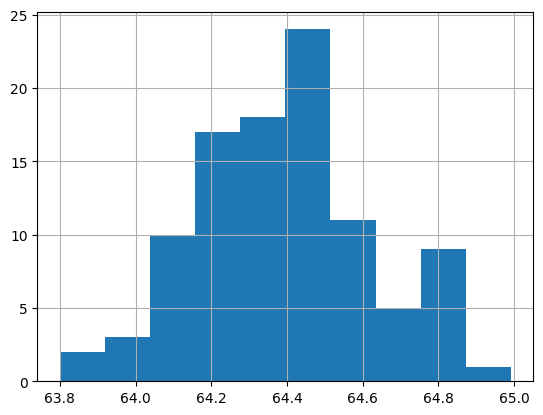

In [40]:
df['EDAD DE JUBILACION'].hist()